In [1]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
B_df, Z_df, labels, per_gene_mean, per_gene_std = cm.get_default_mats()

In [3]:
print(B_df)

            1,REACTOME_TRNA_AMINOACYLATION  \
SRX890545                        -0.047142   
SRX1067711                       -0.138811   
SRX1067710                        0.151608   
SRX762971                        -0.430337   
SRX762970                        -0.631706   
...                                    ...   
SRX3399308                        0.294573   
SRX3399309                        0.291303   
SRX3399310                        0.355084   
SRX3399311                        0.259266   
SRX3399312                        0.287875   

            2,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION  \
SRX890545                                       -0.061672   
SRX1067711                                      -0.072859   
SRX1067710                                       0.037346   
SRX762971                                        0.065104   
SRX762970                                        0.032056   
...                                                   ...   
SRX3399308          

In [4]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values


mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

train_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = train_dummies.columns.tolist()

type2samples = {
            type_: train_dummies.index[train_dummies[type_]== 1].tolist()
            for type_ in celltypes
        }

In [5]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, B_df ):
    samplelist = type2samples[celltype]
    target = pd.Series(0,index = B_df.index)
    target.loc[samplelist] = 1
   
    return(target)

In [6]:
# scaling
from sklearn.preprocessing import StandardScaler

B_transformed = StandardScaler().fit_transform(B_df)

In [7]:
print(B_transformed)

[[-0.10584481 -0.47019708 -0.50972181 ...  0.37631832  0.80168803
  -0.47896199]
 [-0.31166379 -0.55549221 -0.55477734 ... -0.66036274 -0.90773249
  -0.54594177]
 [ 0.34039588  0.28473266 -0.75207435 ... -0.54183414 -0.95381125
  -0.44341844]
 ...
 [ 0.7972488  -0.04392083 -0.5838104  ... -0.46696746  0.37600707
  -0.19816021]
 [ 0.5821132  -0.06131581 -0.76252782 ... -0.68220671 -0.34391528
   0.0874305 ]
 [ 0.64634753 -0.38025891 -0.9130753  ... -0.75837763 -0.16838475
   0.25043433]]


In [8]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

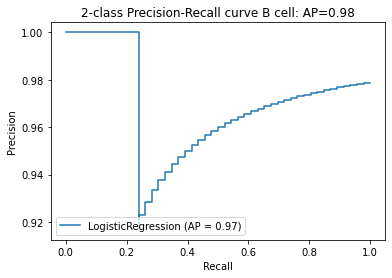

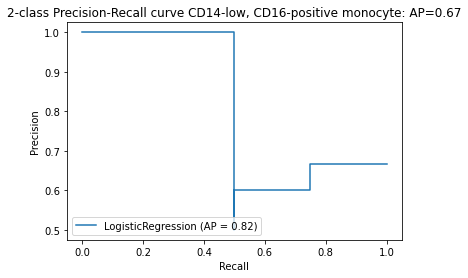

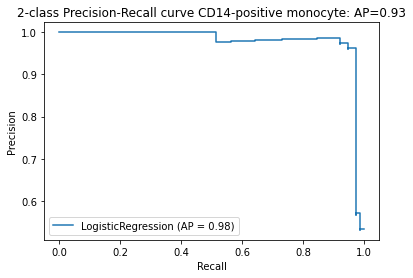

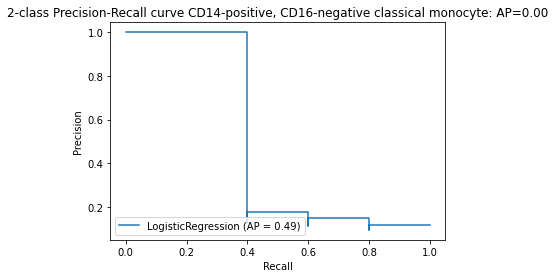

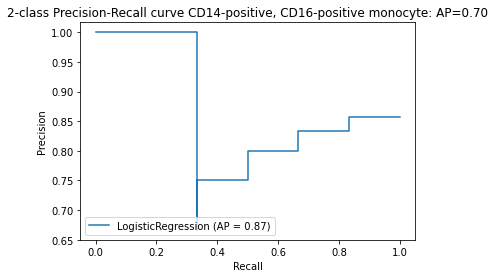

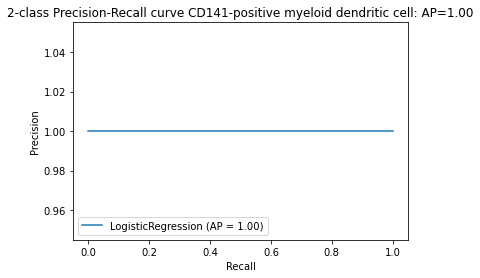

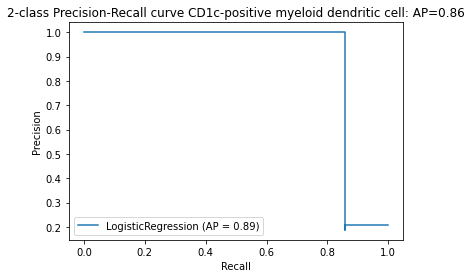

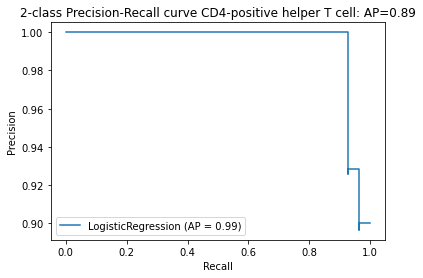

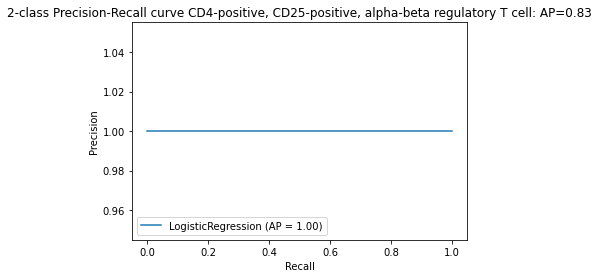

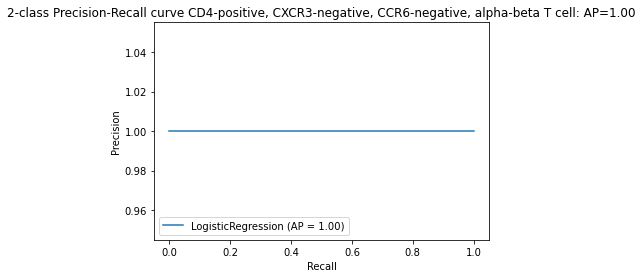

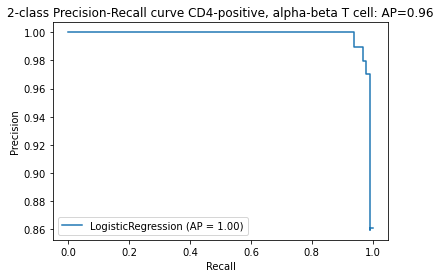

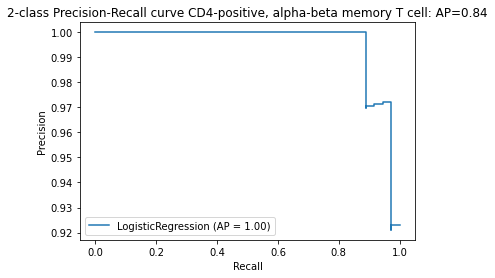

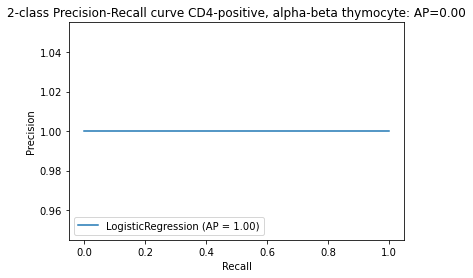

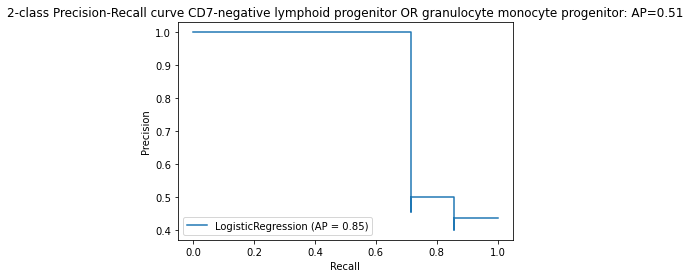

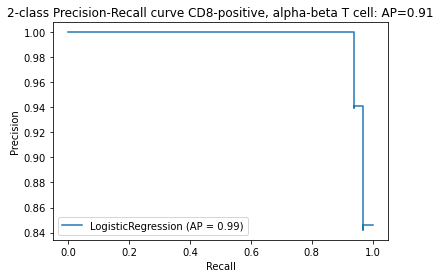

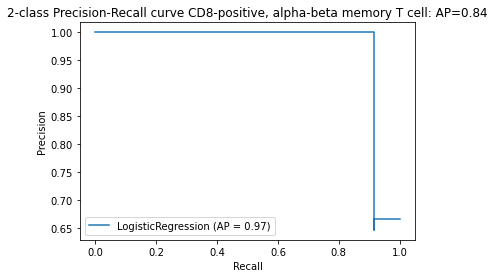

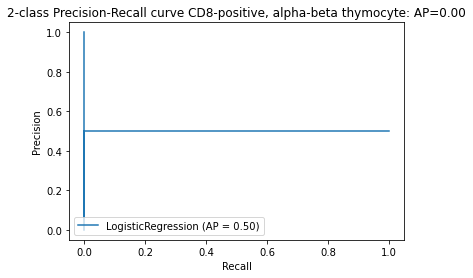

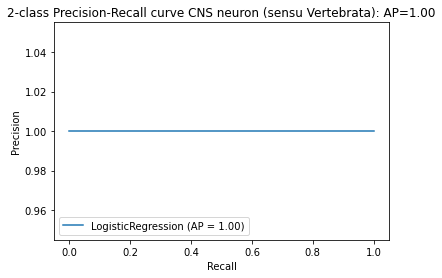

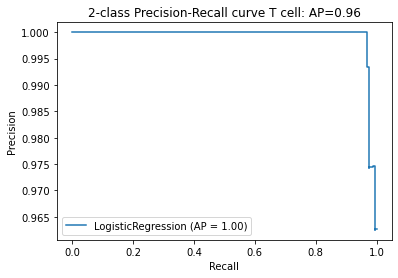

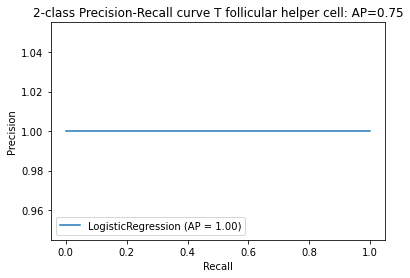

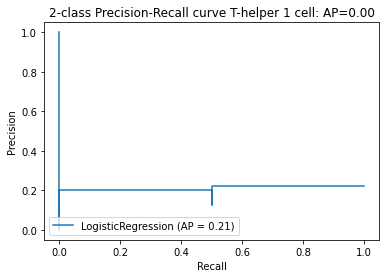

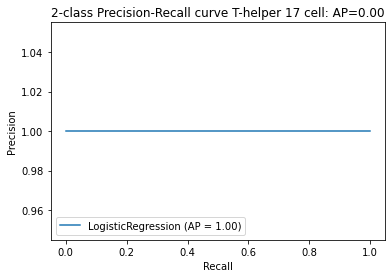

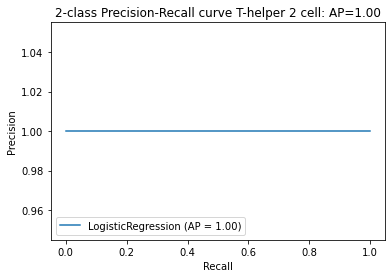

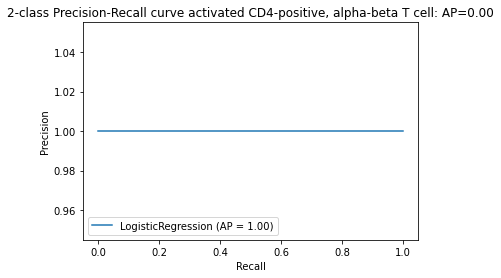

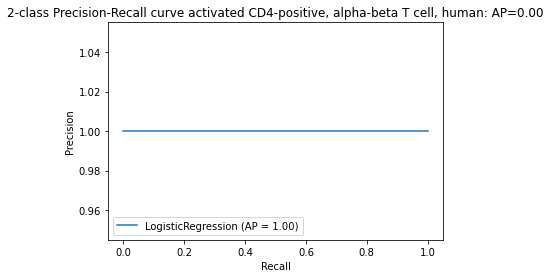

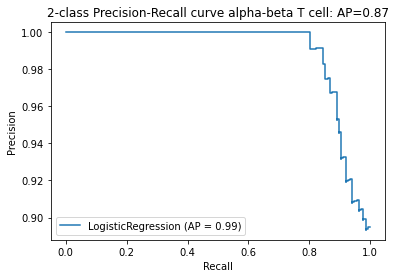

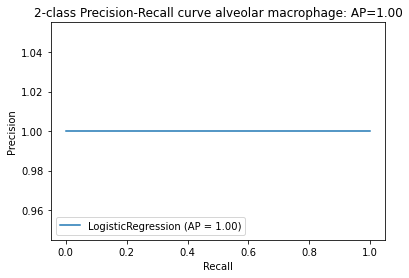

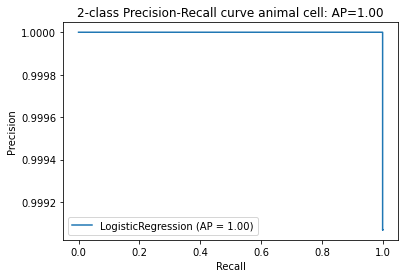

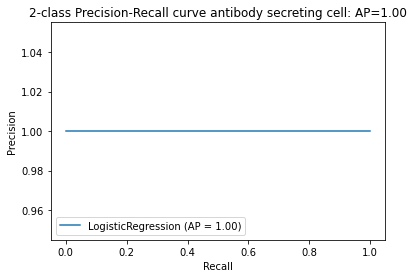

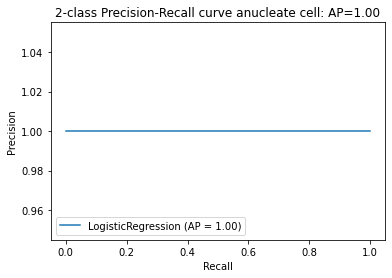

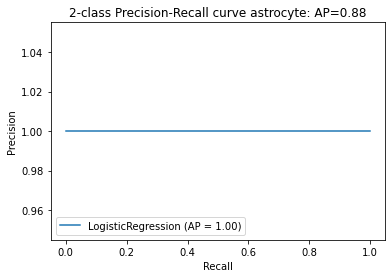

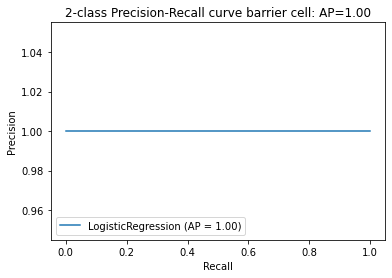

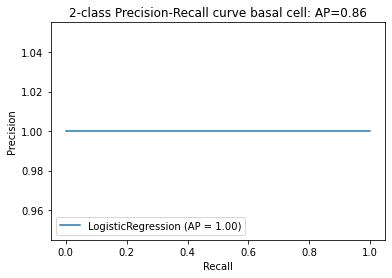

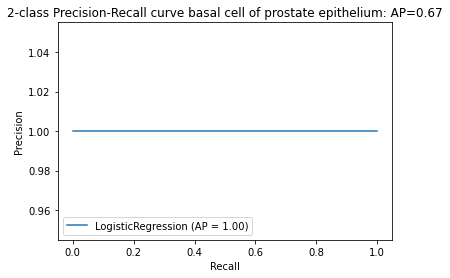

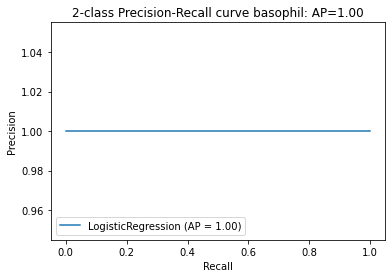

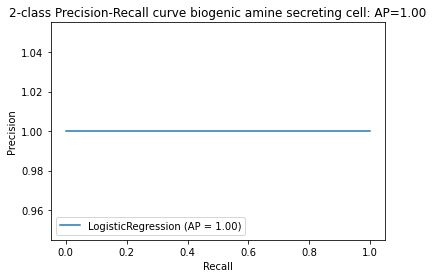

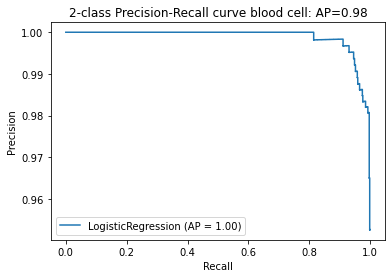

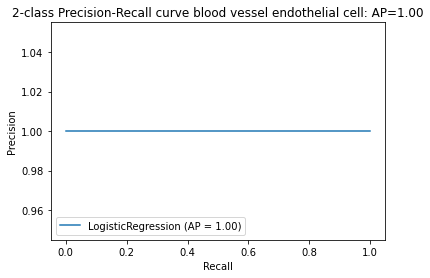

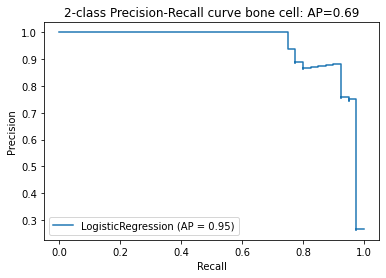

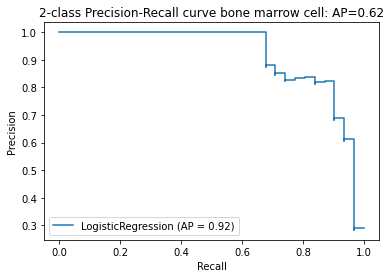

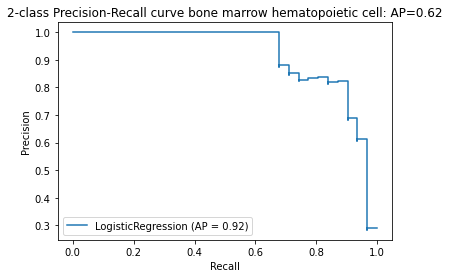

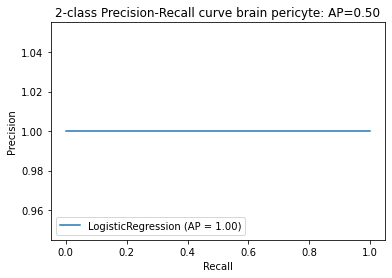

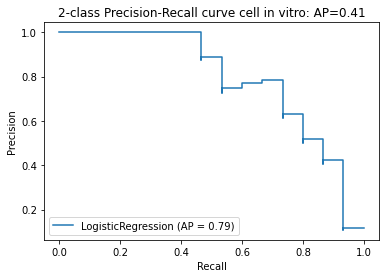

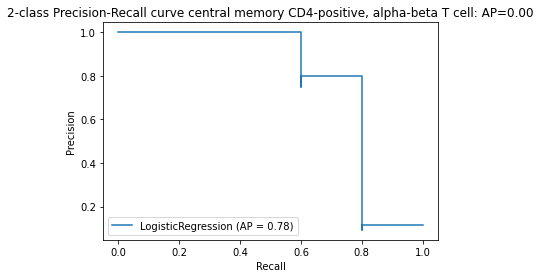

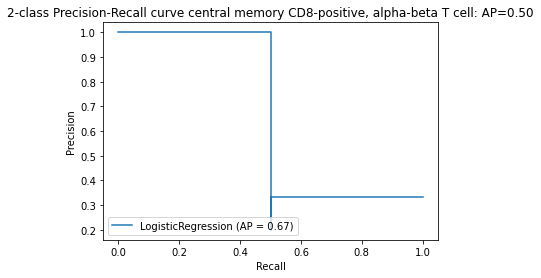

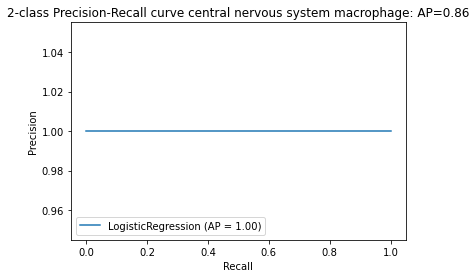

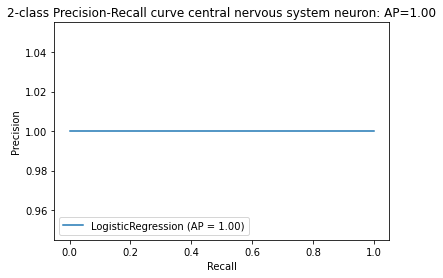

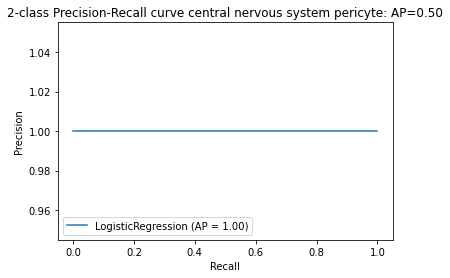

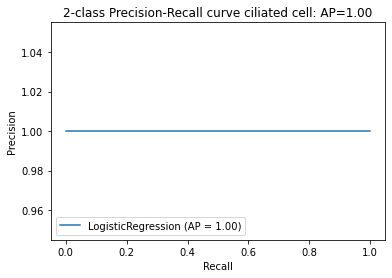

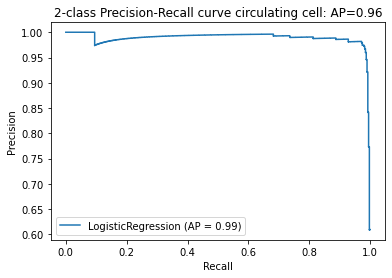

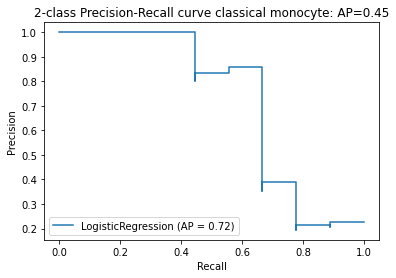

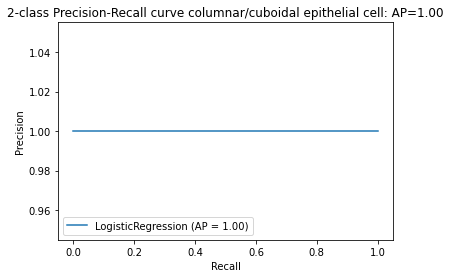

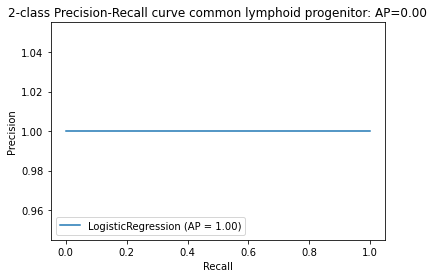

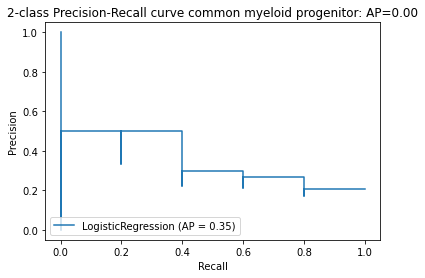

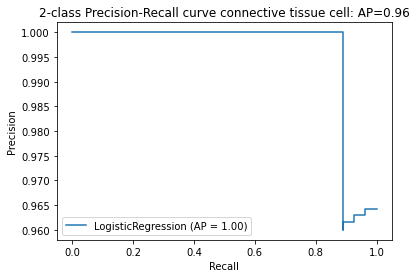

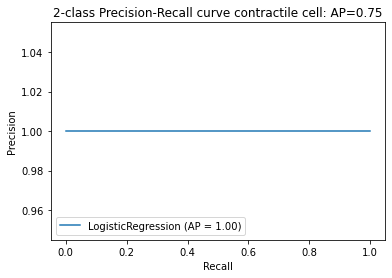

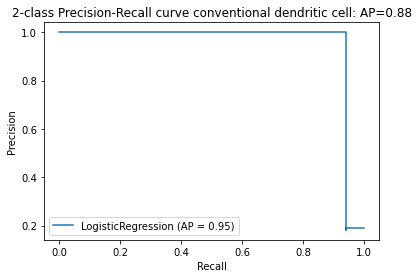

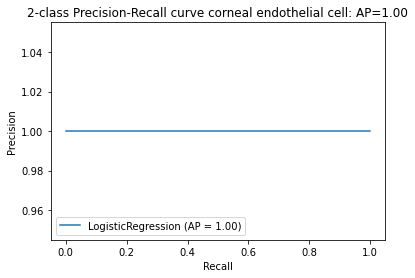

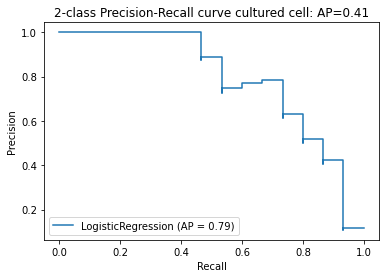

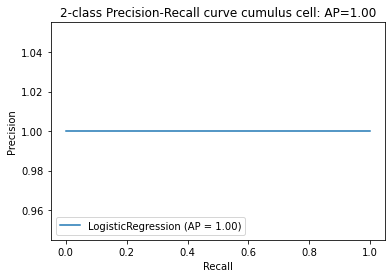

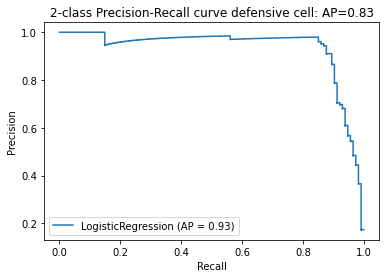

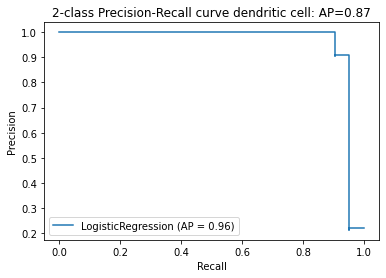

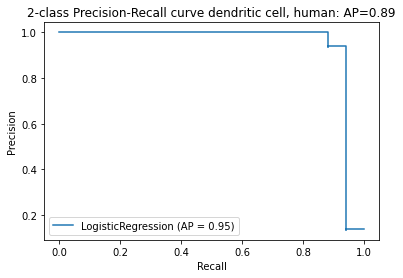

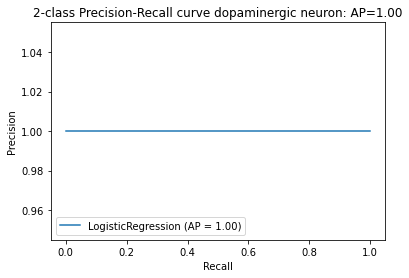

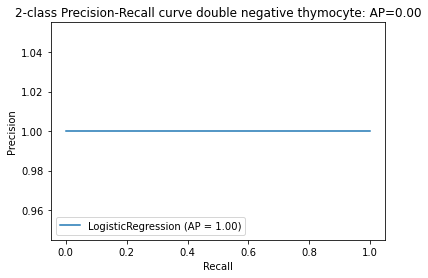

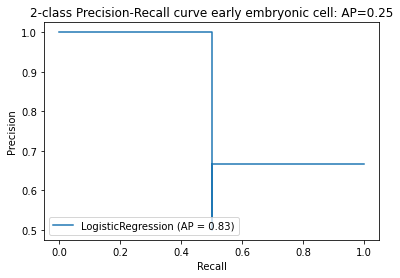

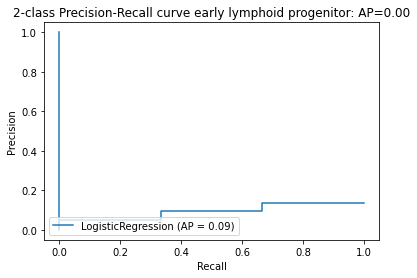

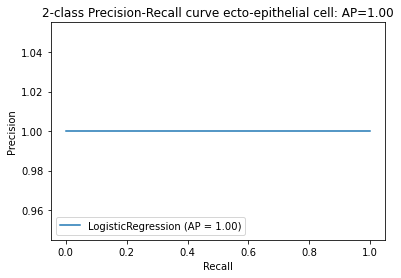

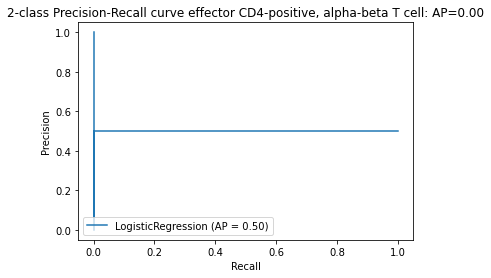

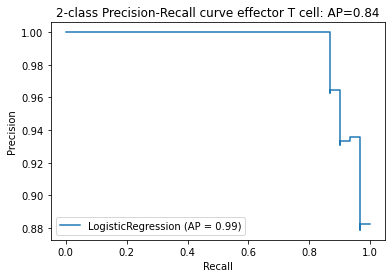

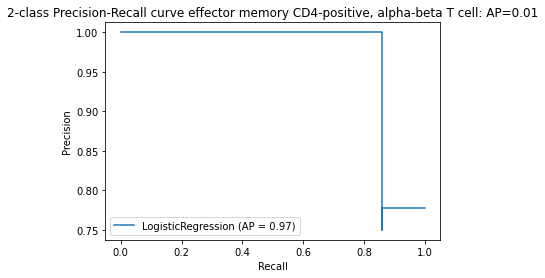

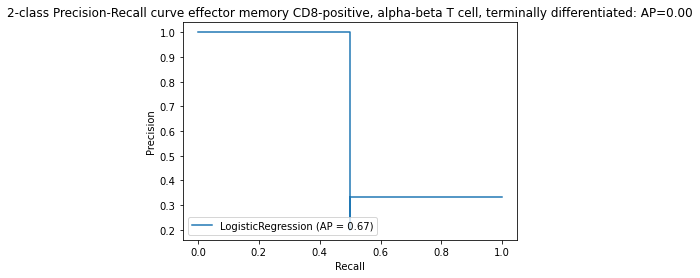

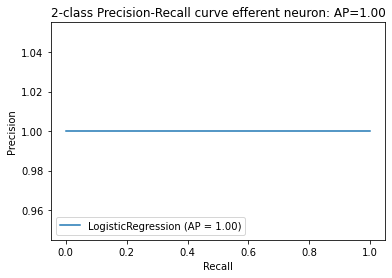

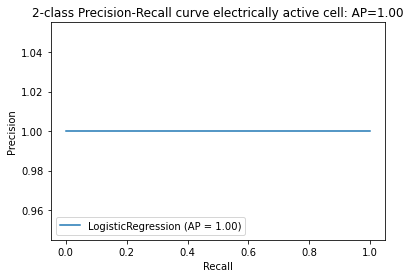

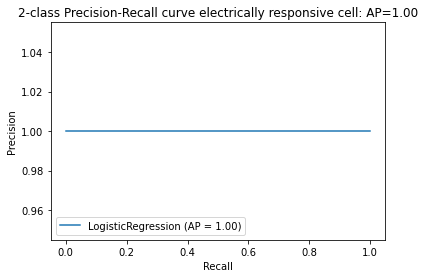

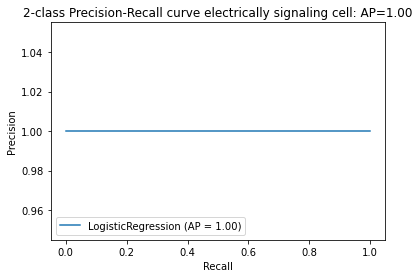

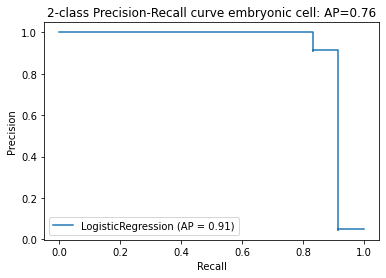

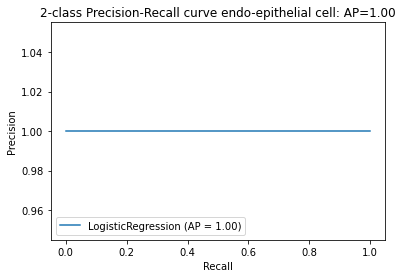

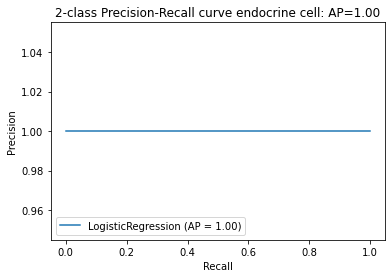

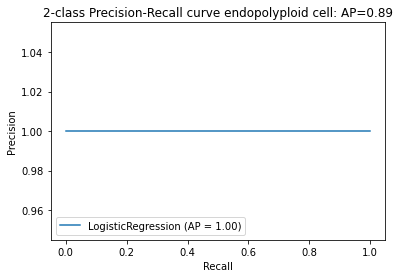

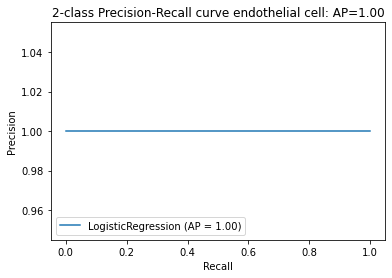

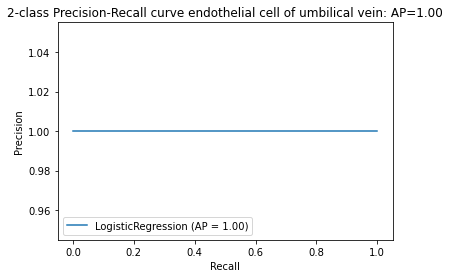

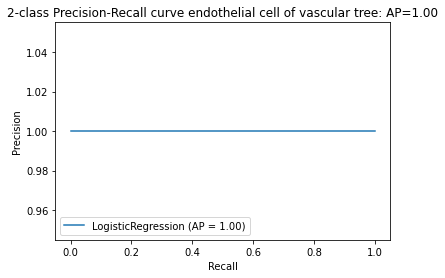

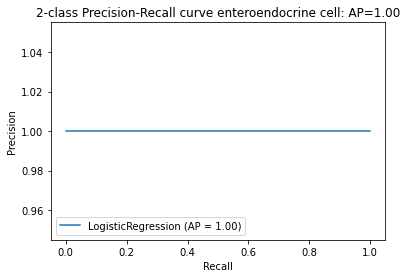

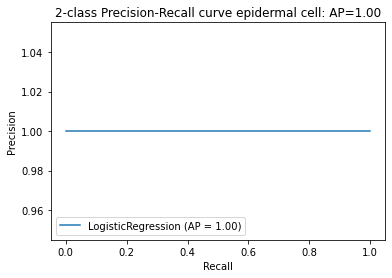

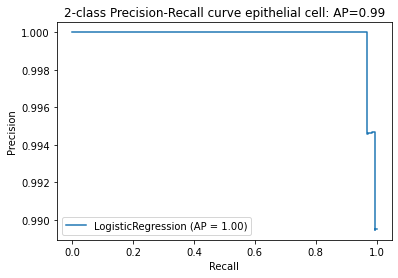

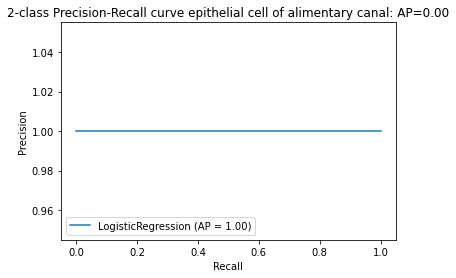

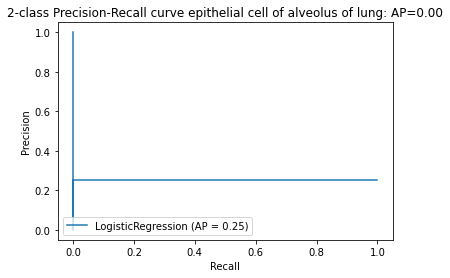

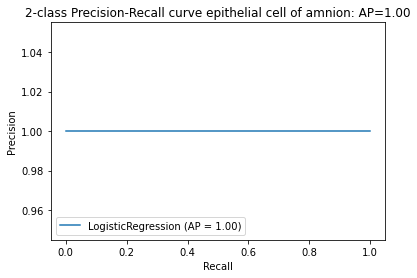

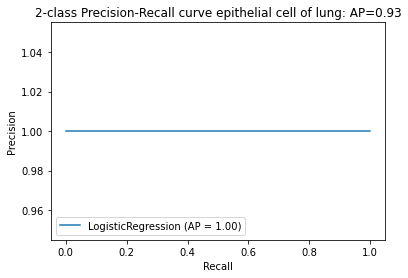

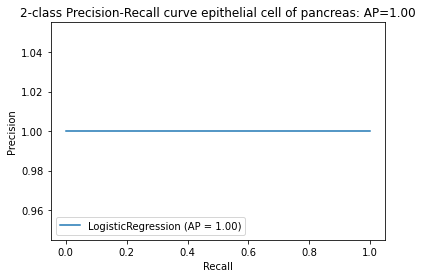

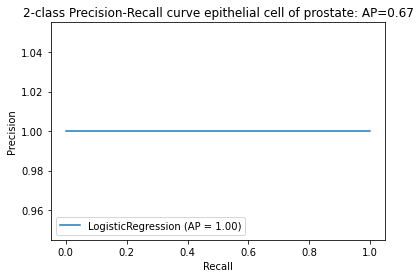

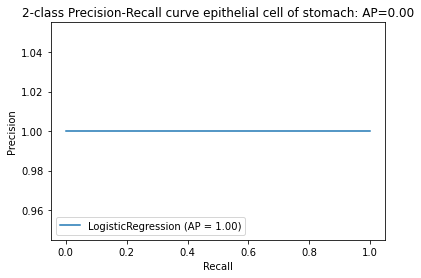

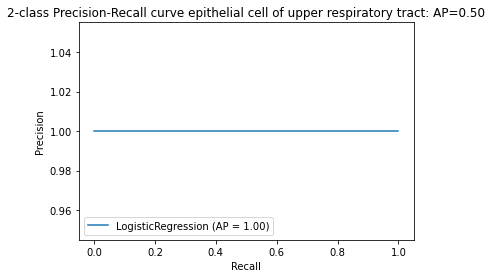

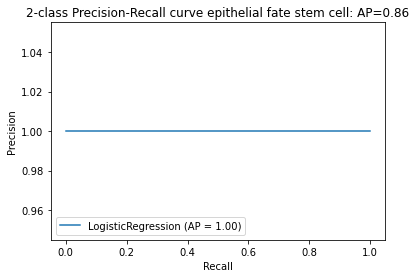

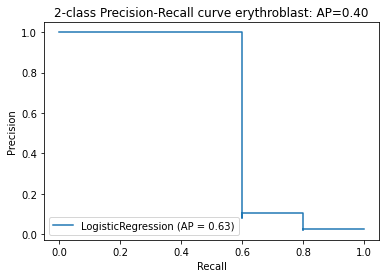

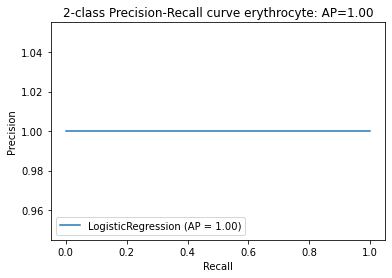

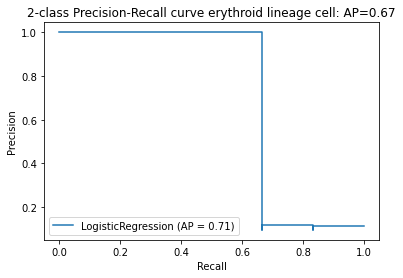

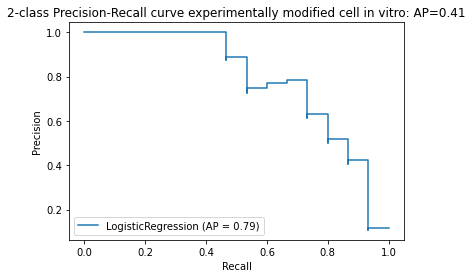

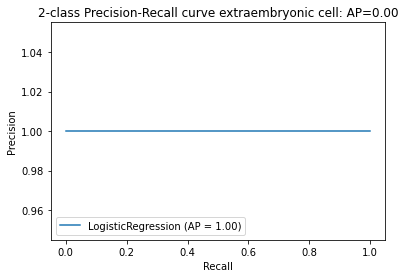

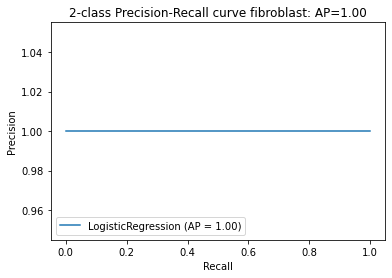

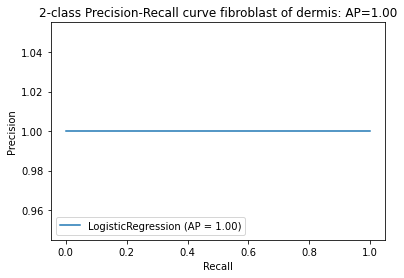

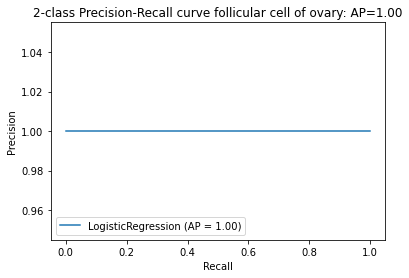

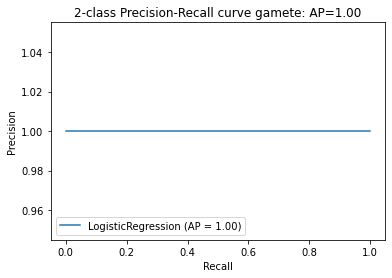

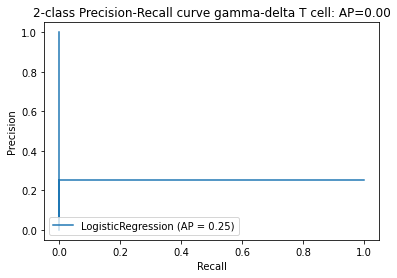

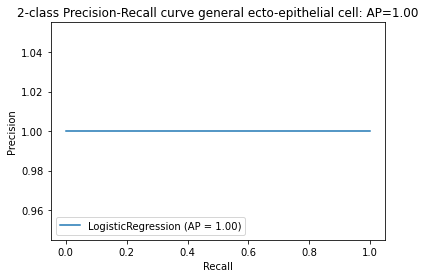

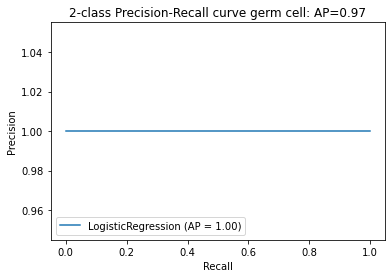

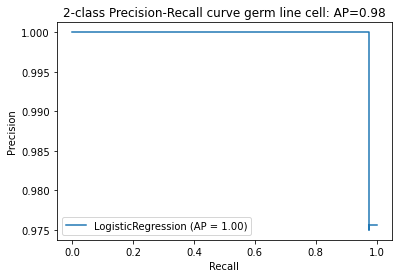

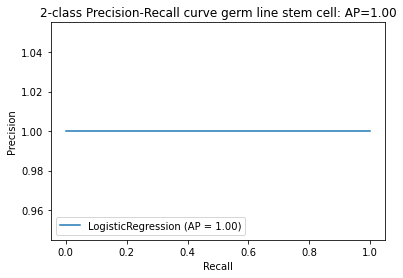

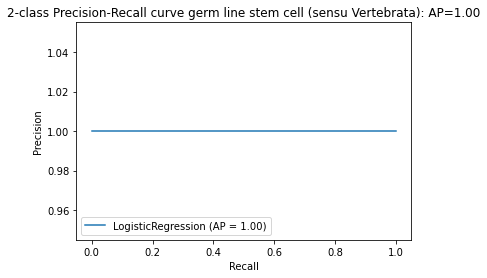

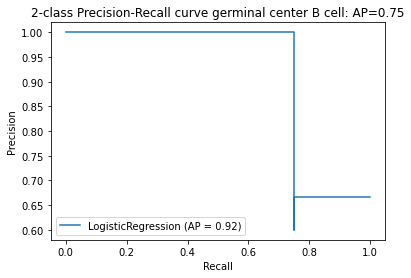

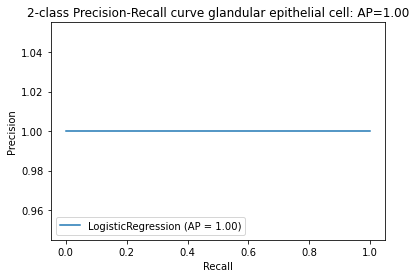

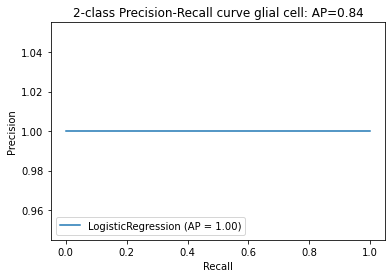

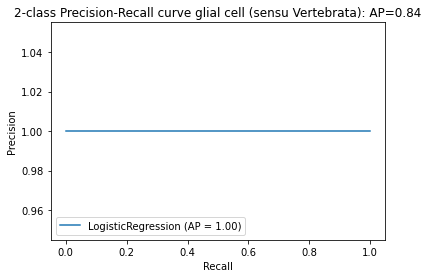

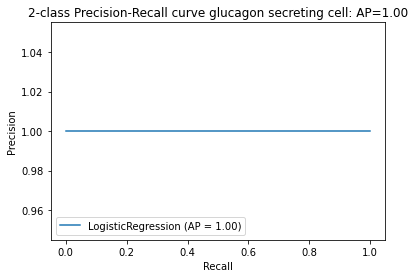

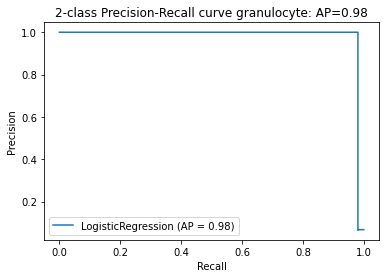

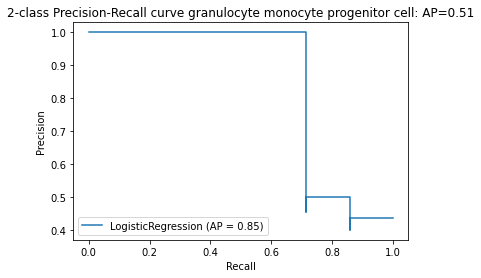

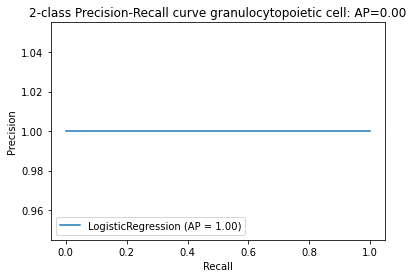

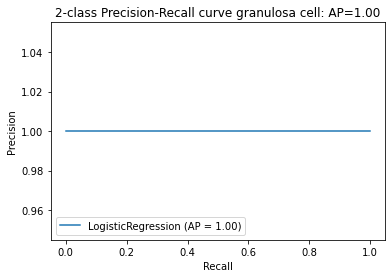

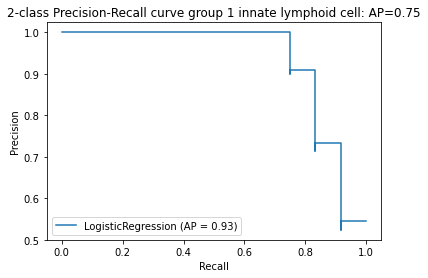

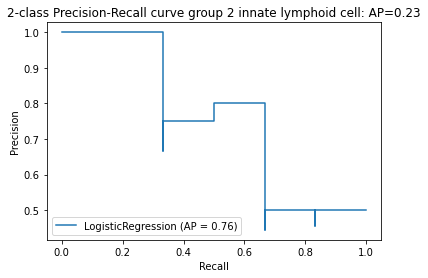

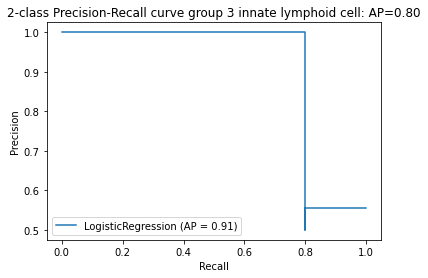

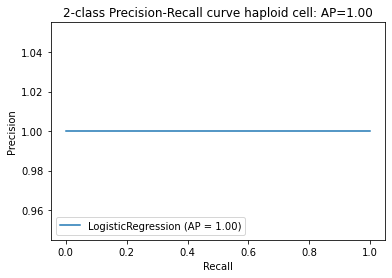

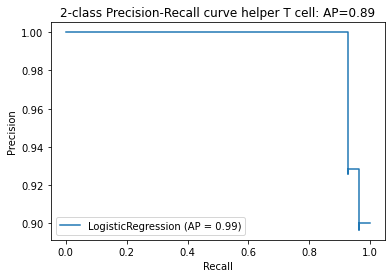

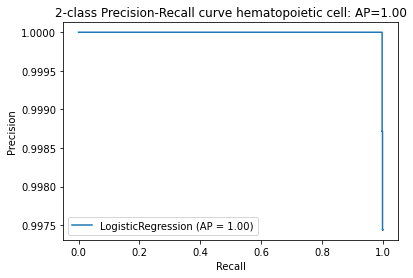

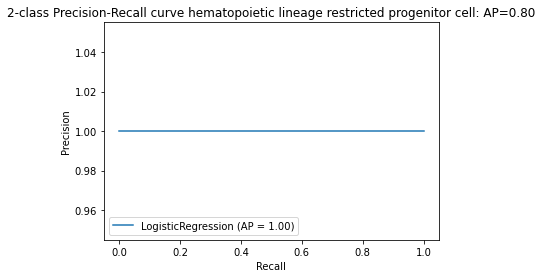

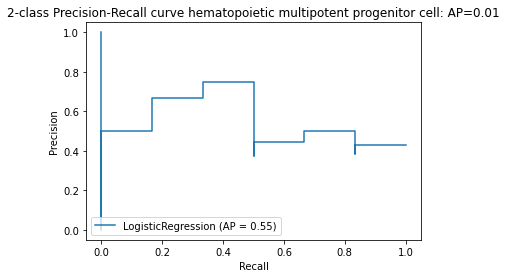

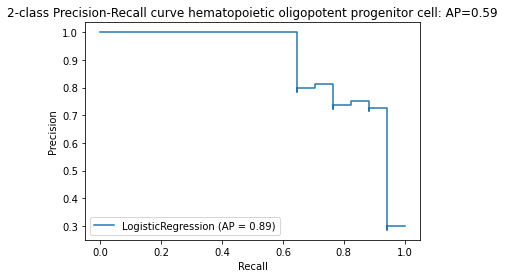

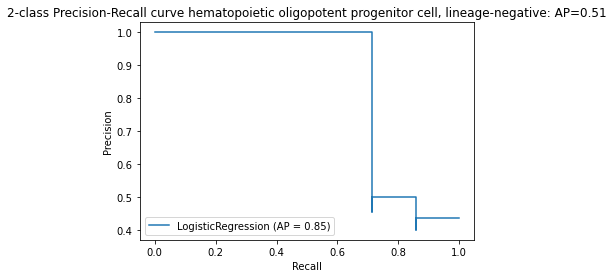

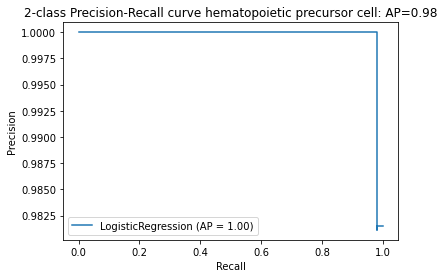

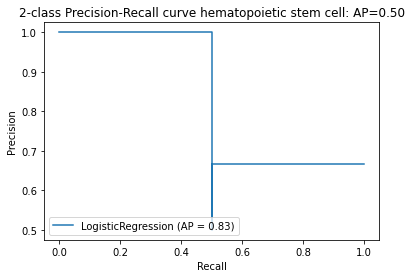

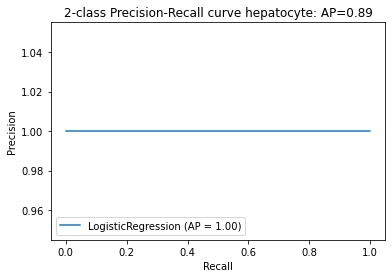

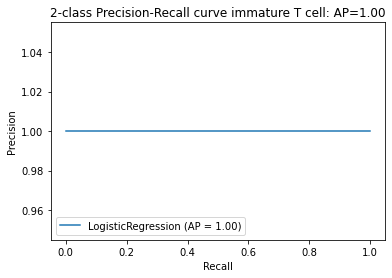

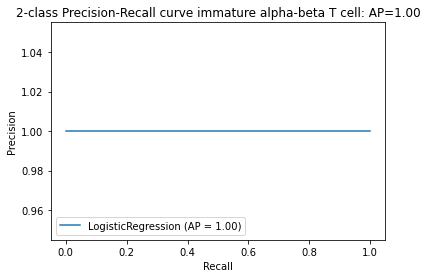

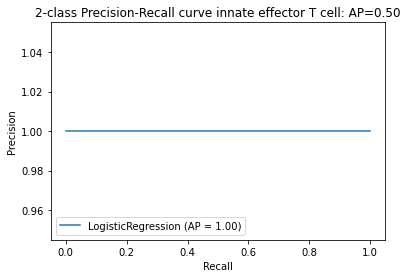

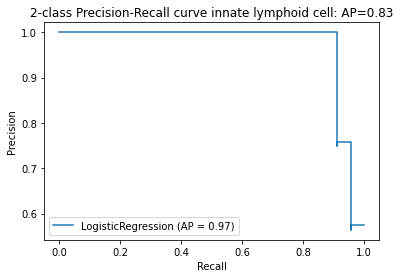

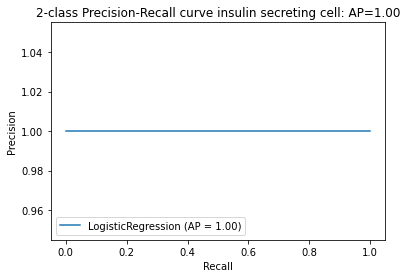

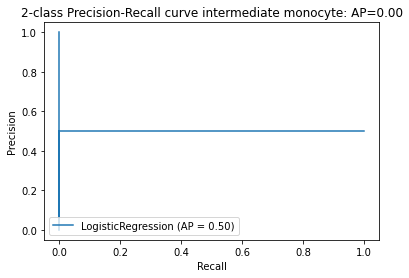

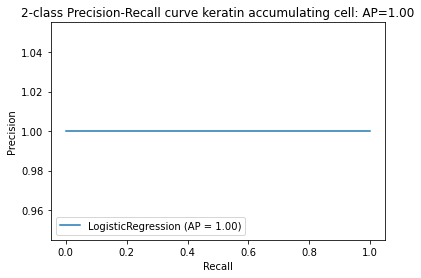

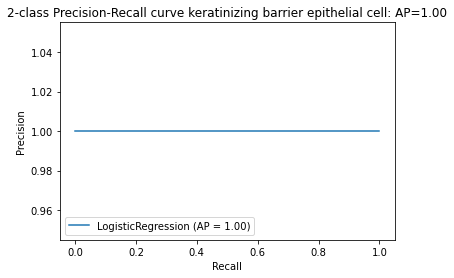

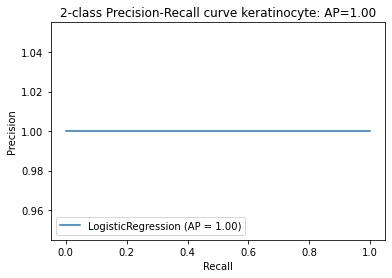

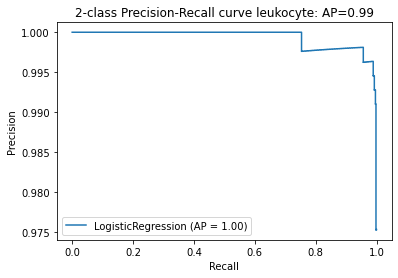

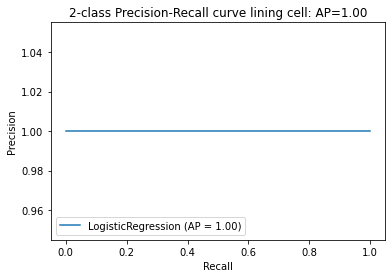

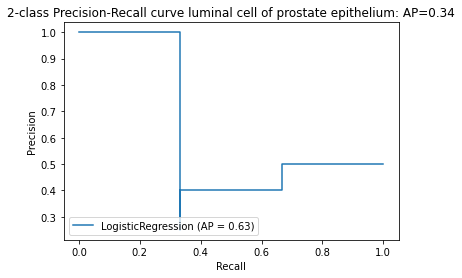

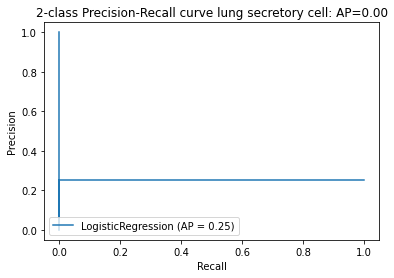

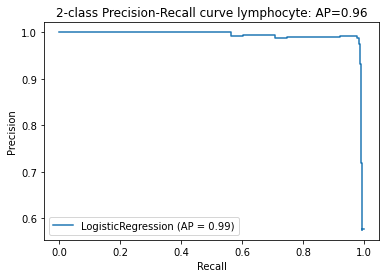

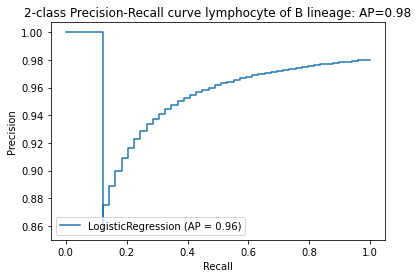

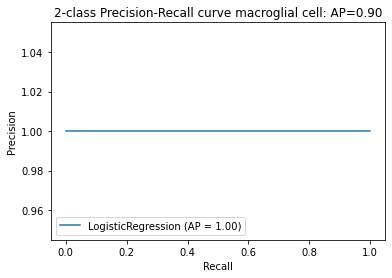

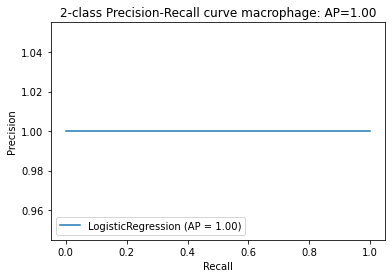

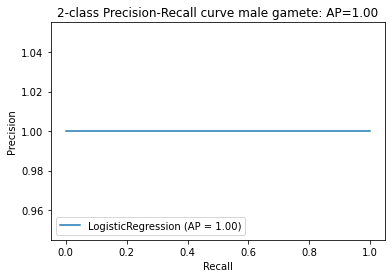

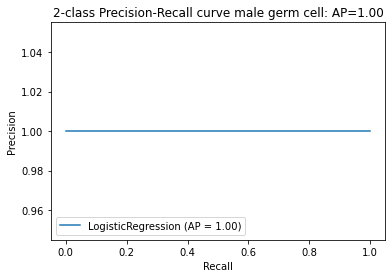

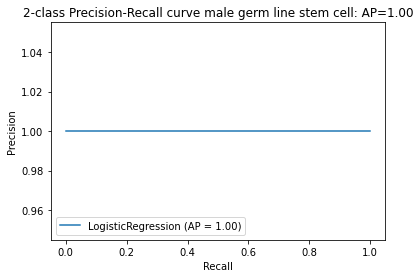

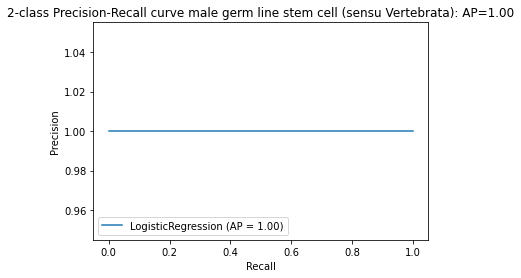

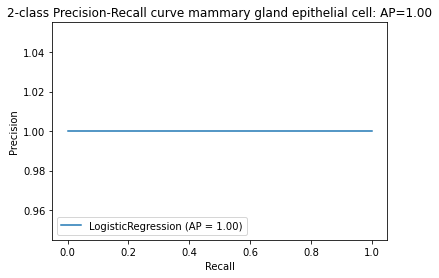

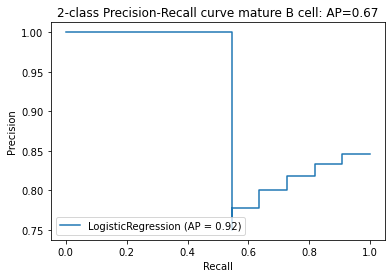

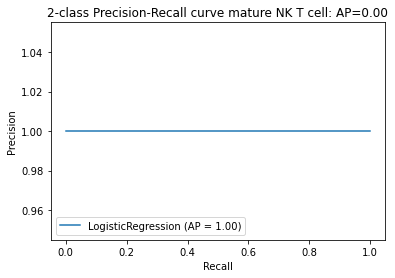

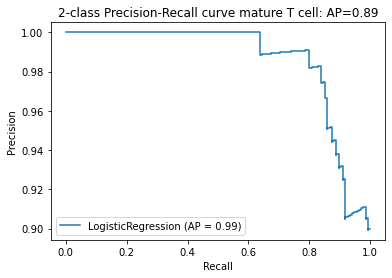

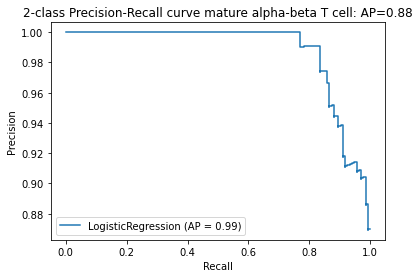

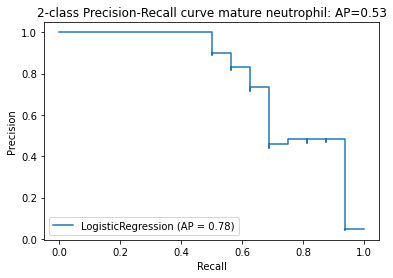

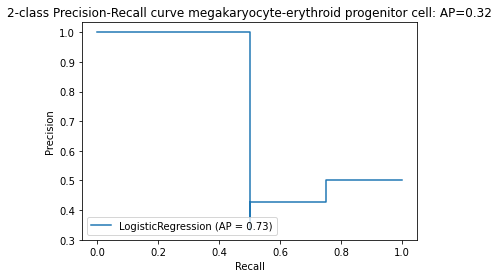

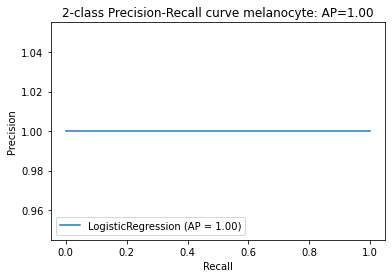

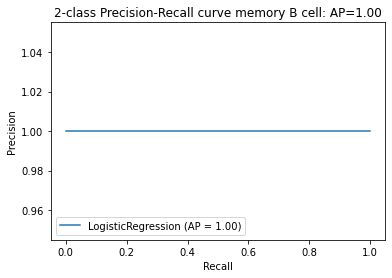

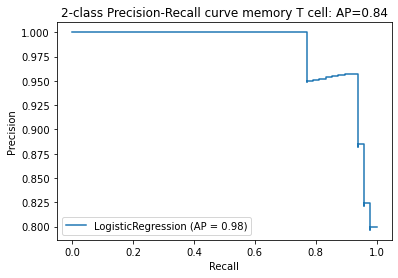

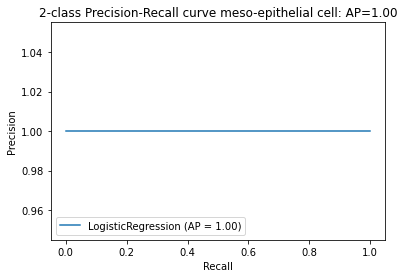

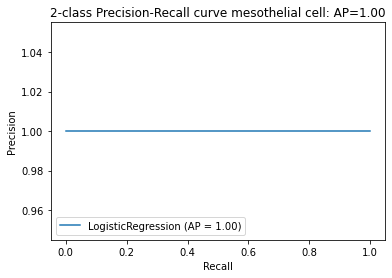

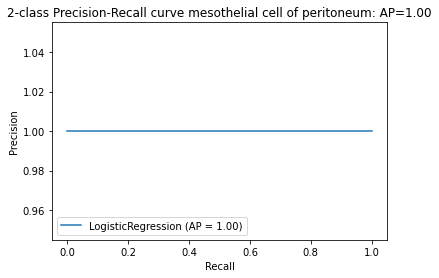

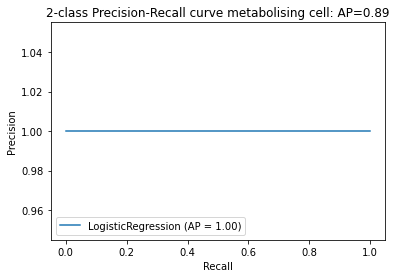

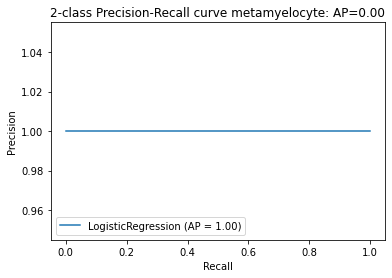

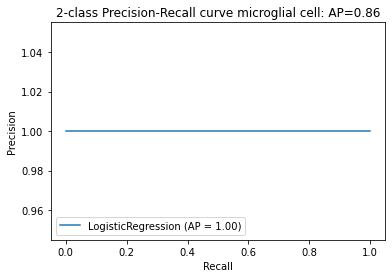

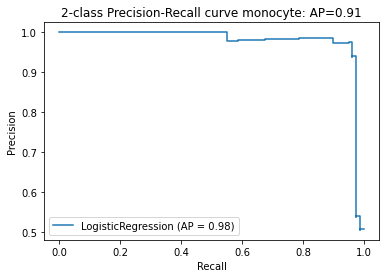

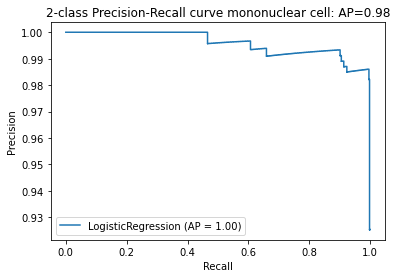

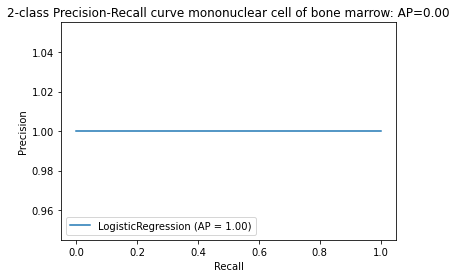

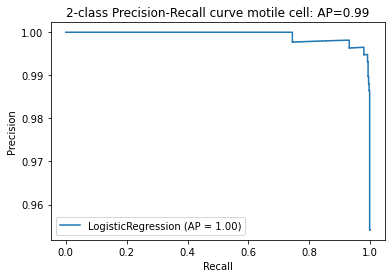

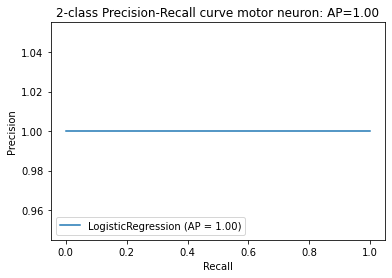

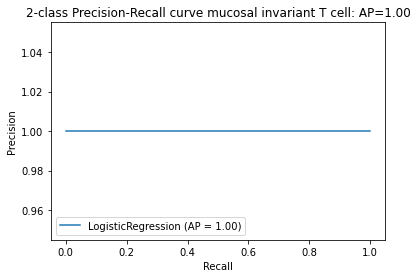

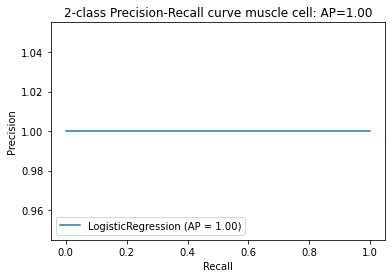

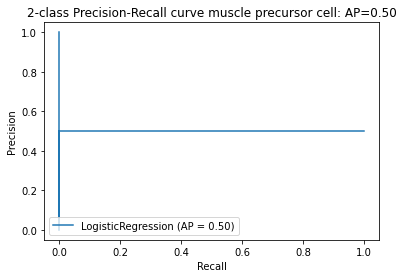

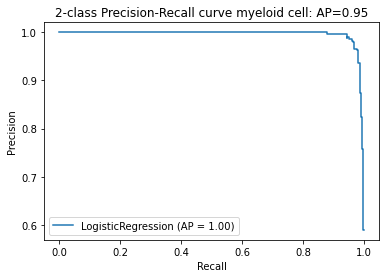

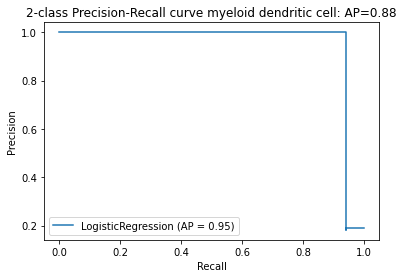

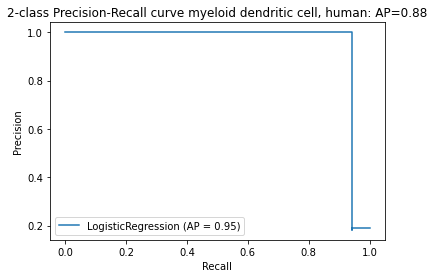

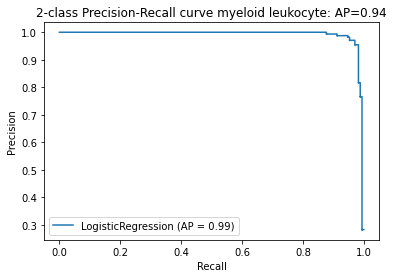

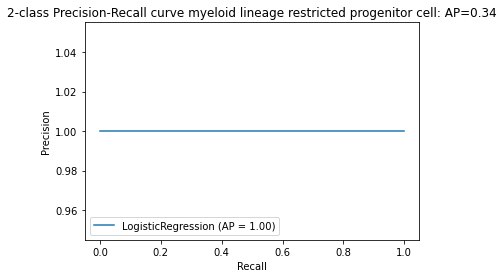

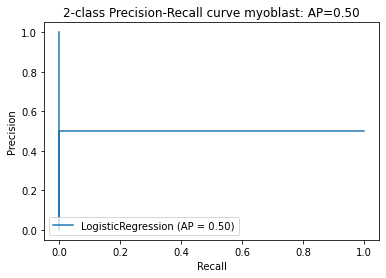

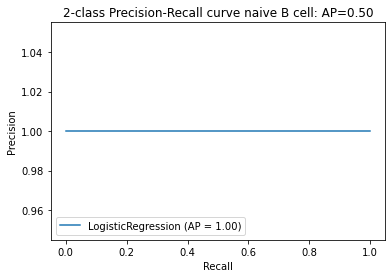

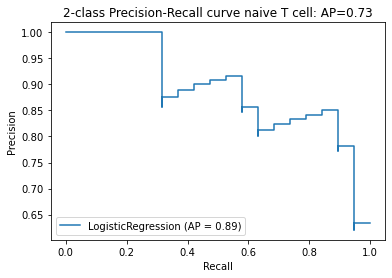

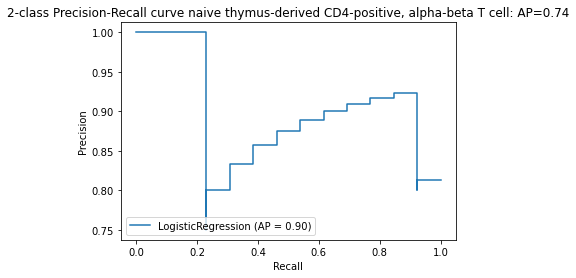

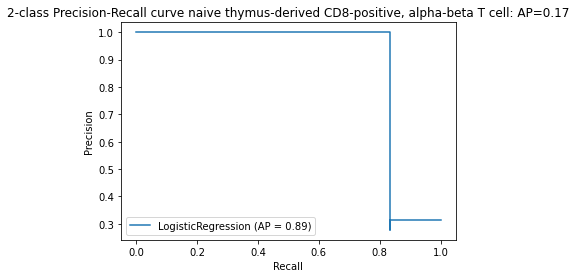

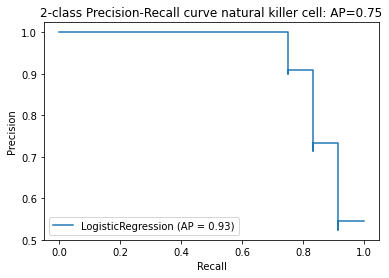

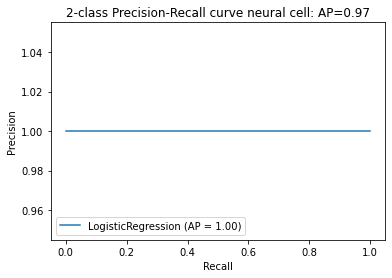

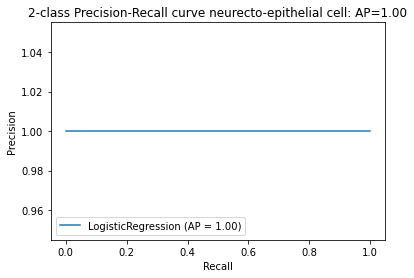

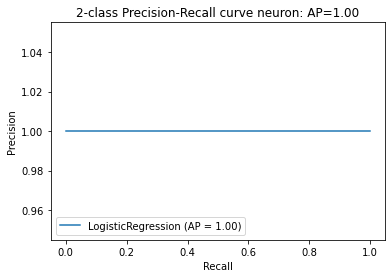

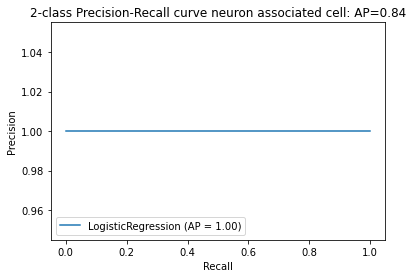

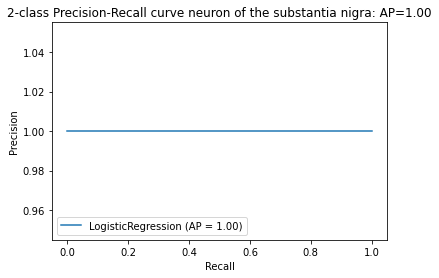

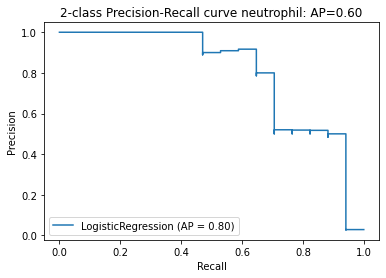

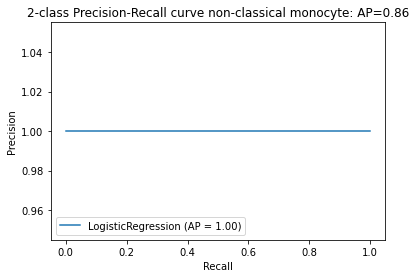

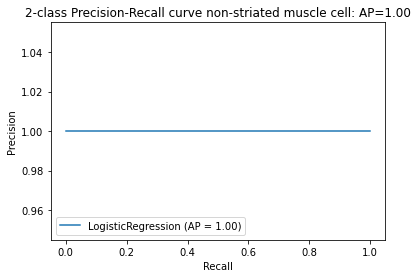

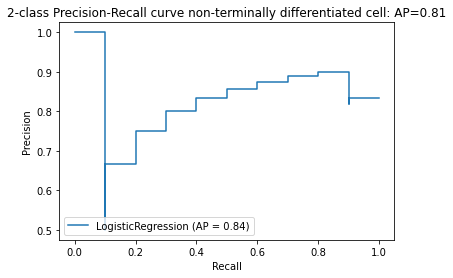

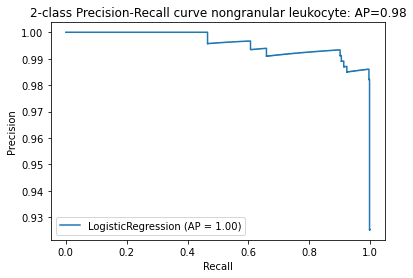

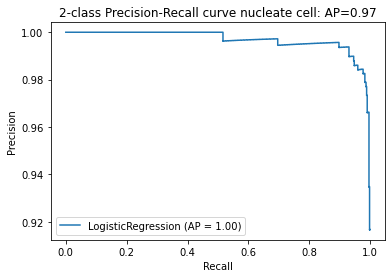

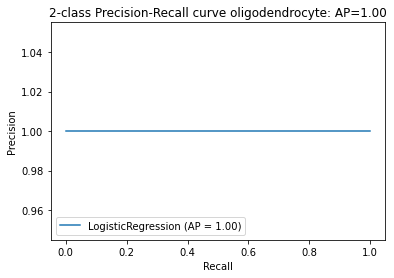

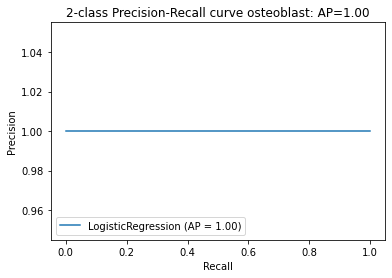

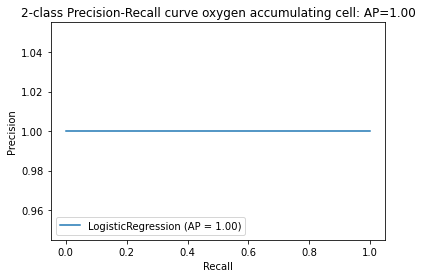

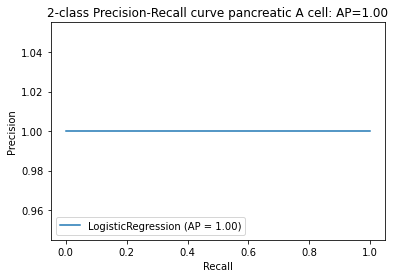

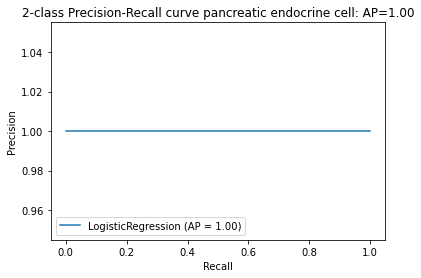

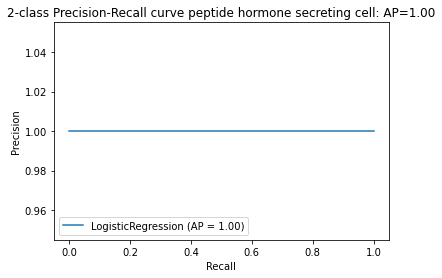

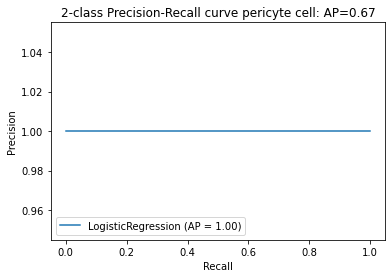

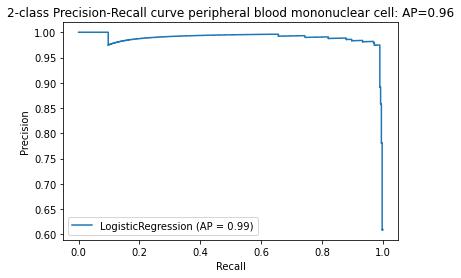

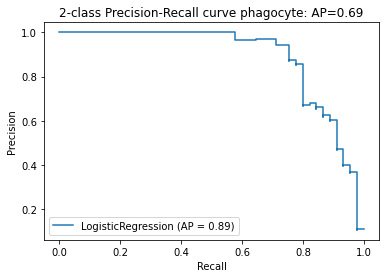

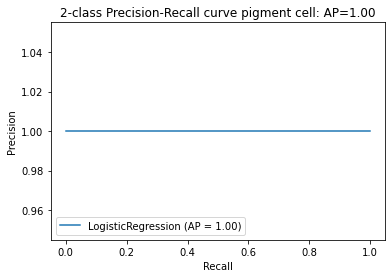

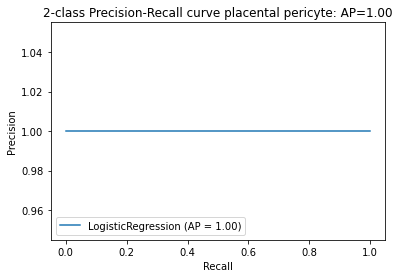

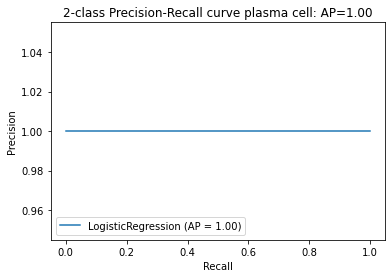

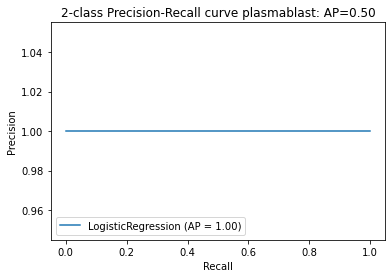

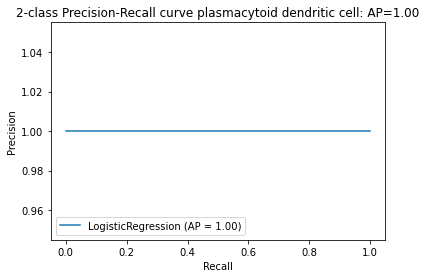

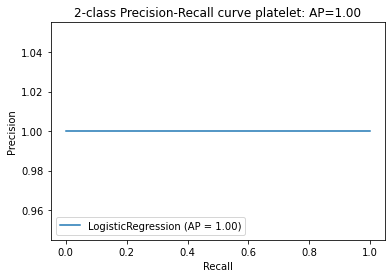

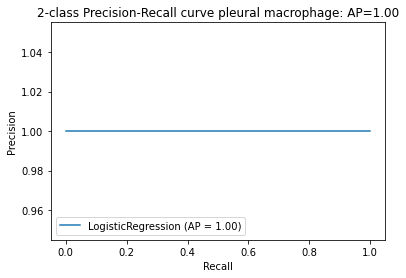

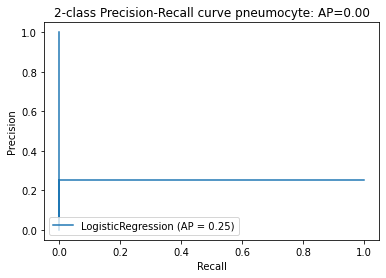

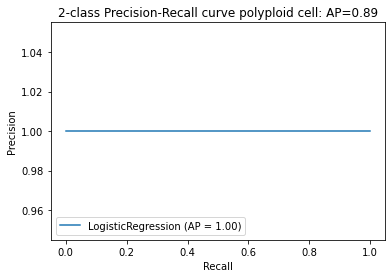

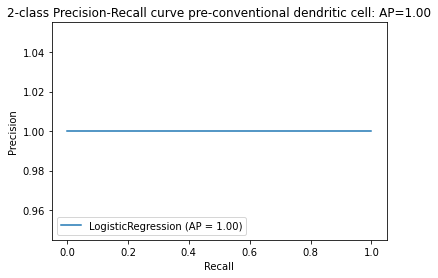

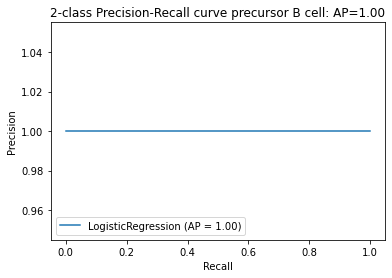

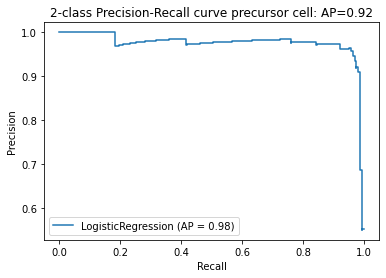

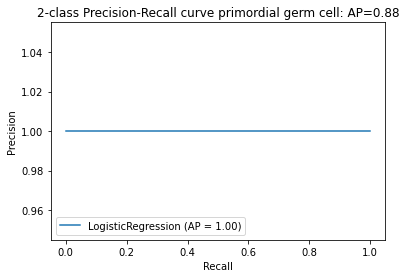

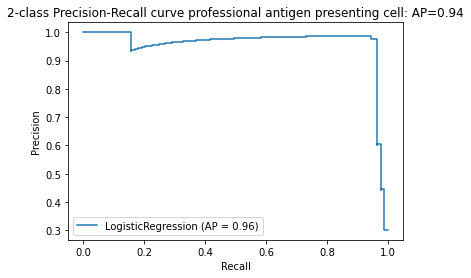

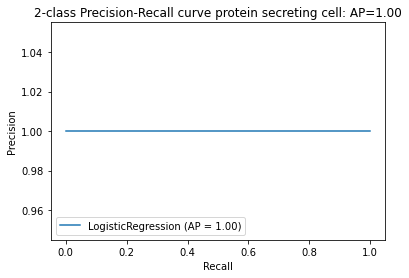

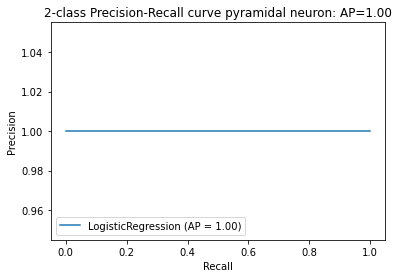

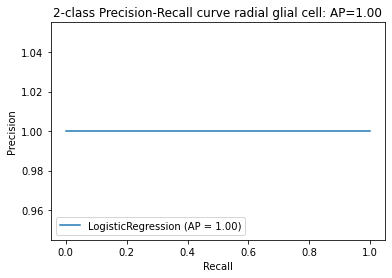

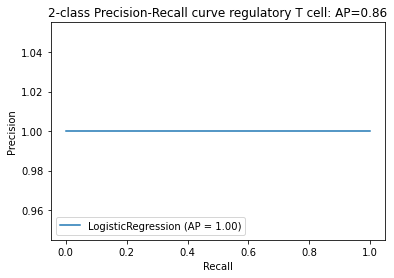

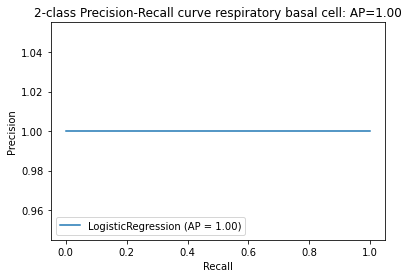

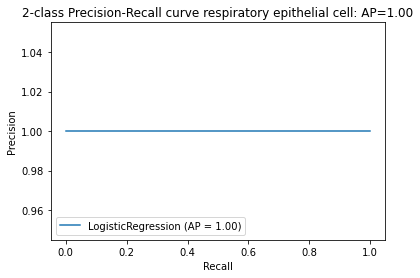

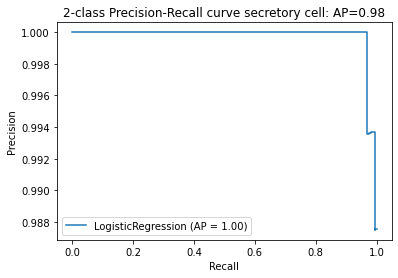

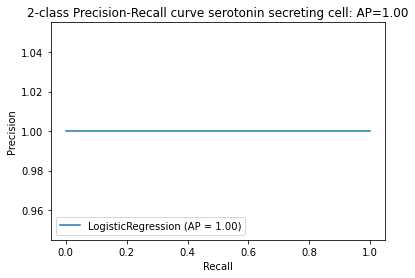

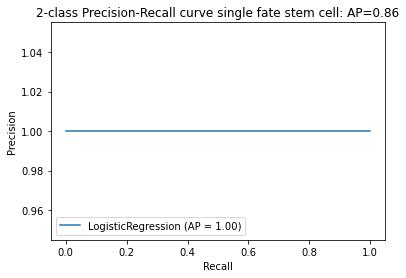

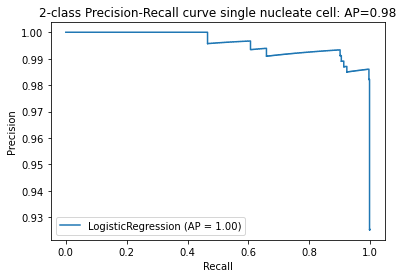

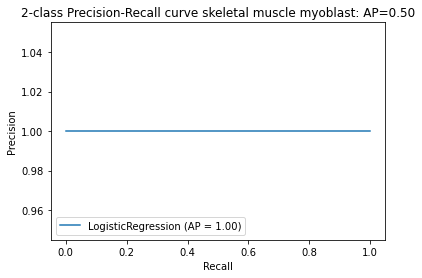

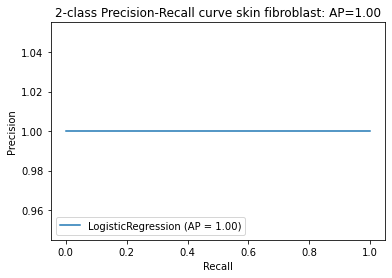

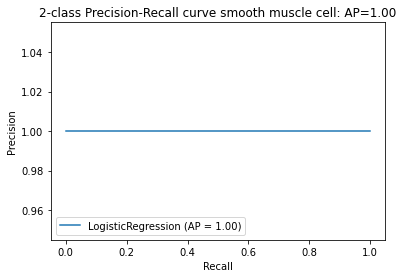

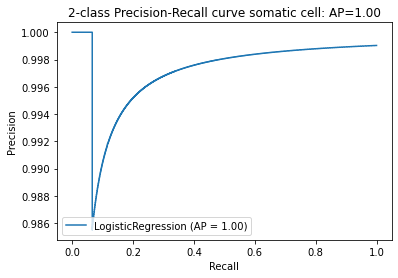

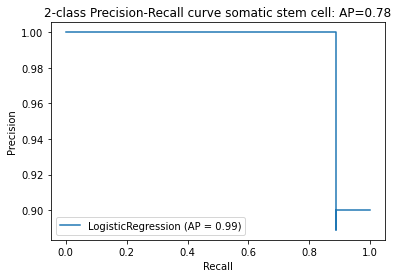

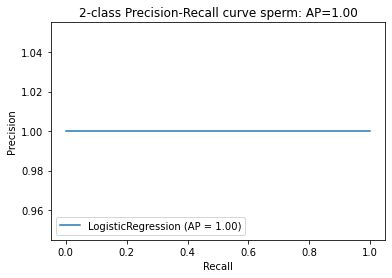

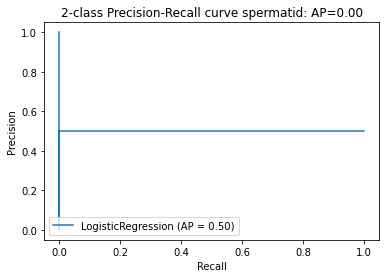

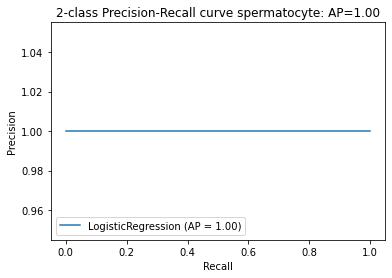

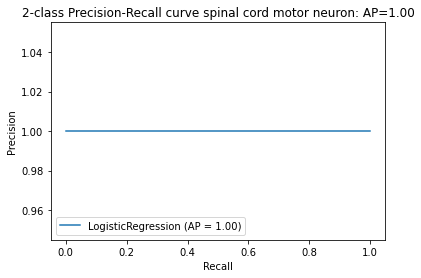

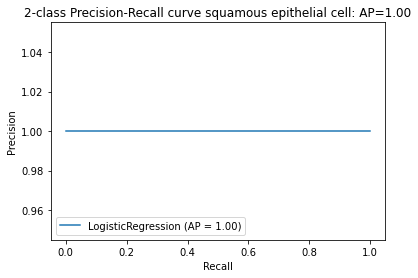

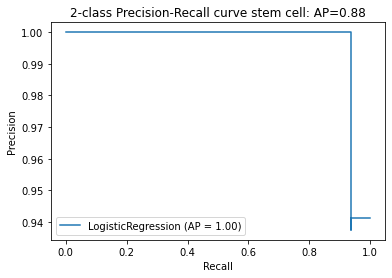

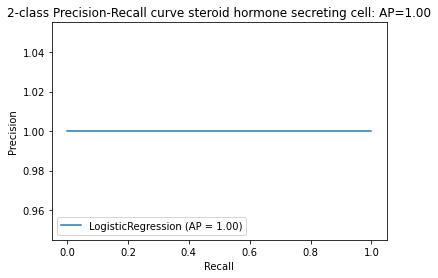

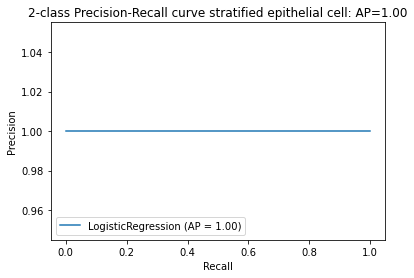

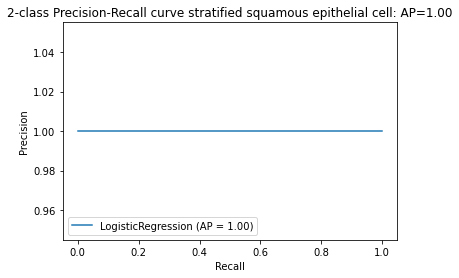

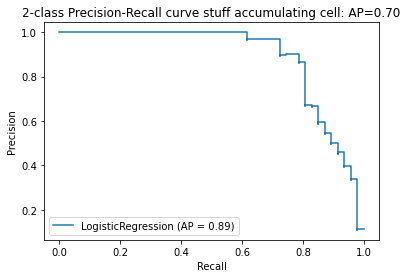

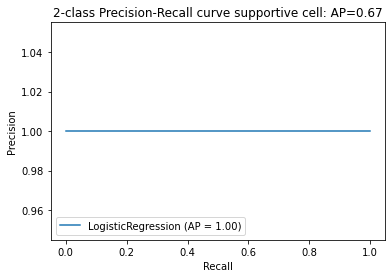

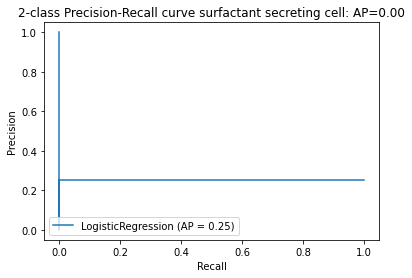

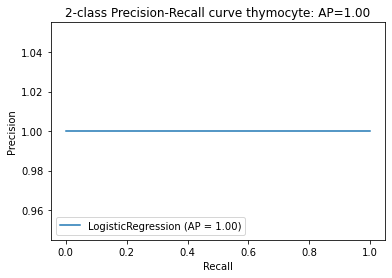

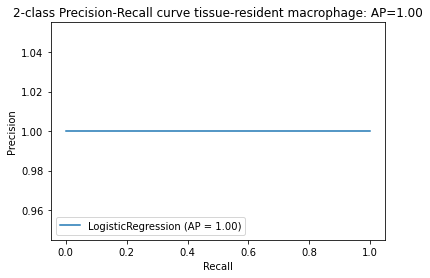

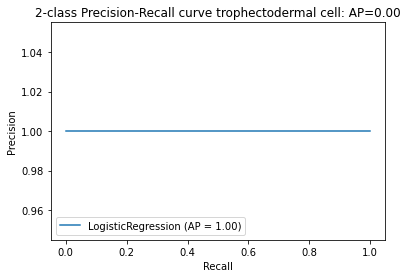

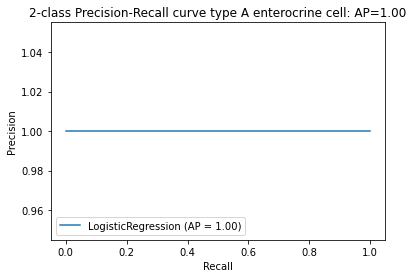

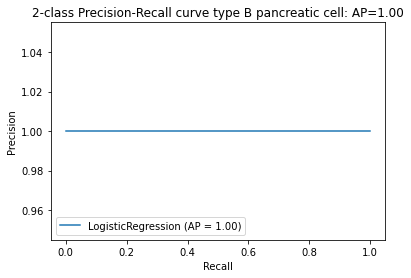

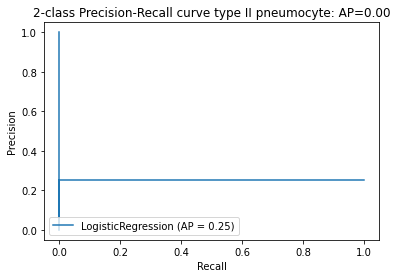

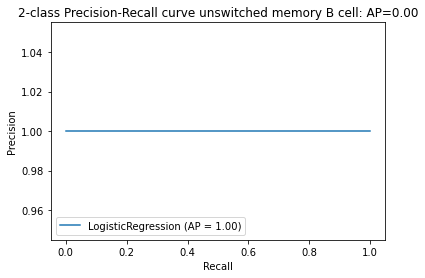

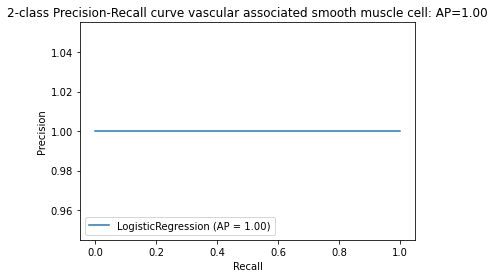

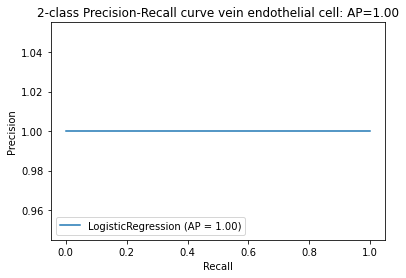

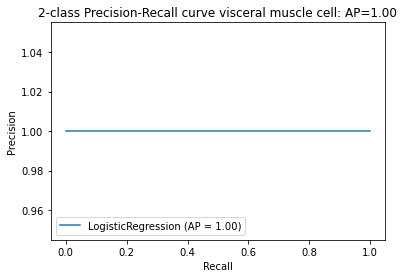

In [9]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

successful_celltypes =[]
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []
for cell_type in celltypes:
   
    target = set_target(cell_type ,type2samples, B_df )
    train_data, test_data, train_target, train_test = train_test_split(B_transformed, target.values, test_size=0.25,random_state = 111) # 75% training data
    if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
        # lasso penalty
        clf = LogisticRegression(solver = "saga",penalty = "l1",random_state=111 )
        
        clf.fit(train_data, train_target)
        target_pred= clf.predict(test_data)
        test_pr = metrics.average_precision_score(train_test, target_pred)
        test_precision += [precision_score(train_test, target_pred)]
        test_recall += [recall_score(train_test, target_pred)]
        fscores += [fscore(test_precision[-1], test_recall[-1])]
        successful_celltypes += [cell_type]
        #plot precision recall curve for celltype
        disp = plot_precision_recall_curve(clf, test_data, train_test)
        disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
    else:
        unsuccessful_celltypes += [cell_type]
        
p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 

report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),columns = ["celltype","precision score","recall score","f score"])


In [10]:
print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

precision: 0.8436, recall: 0.7846, f1: 0.4016, f1 micro avg: 0.4065


In [11]:
report

,celltype,precision score,recall score,f score
0,B cell,0.978723,1.000000,0.494624
1,"CD14-low, CD16-positive monocyte",0.666667,1.000000,0.400000
2,CD14-positive monocyte,0.950000,0.974359,0.481013
3,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
4,"CD14-positive, CD16-positive monocyte",0.833333,0.833333,0.416667
...,...,...,...,...
254,type II pneumocyte,0.000000,0.000000,0.000000
255,unswitched memory B cell,0.000000,0.000000,0.000000
256,vascular associated smooth muscle cell,1.000000,1.000000,0.500000
257,vein endothelial cell,1.000000,1.000000,0.500000


In [12]:
print(len(unsuccessful_celltypes))
unsuccessful_celltypes

58


['Bm4 B cell',
 'IgD-negative memory B cell',
 'IgG memory B cell',
 'IgM memory B cell',
 'Kupffer cell',
 'Merkel cell',
 'Sertoli cell',
 'adult endothelial progenitor cell',
 'androgen binding protein secreting cell',
 'angioblastic mesenchymal cell',
 'brain microvascular endothelial cell',
 'carbohydrate secreting cell',
 'cell',
 'cerebellar granule cell',
 'cerebellar neuron',
 'chondrocyte',
 'class switched memory B cell',
 'collagen secreting cell',
 'common myeloid progenitor, CD34-positive',
 'cord blood hematopoietic stem cell',
 'corona radiata cell',
 'double-positive, alpha-beta thymocyte',
 'duct epithelial cell',
 'effector memory CD8-positive, alpha-beta T cell',
 'endothelial cell of artery',
 'epidermal melanocyte',
 'epithelial cell of exocrine pancreas',
 'epithelial cell of gall bladder',
 'epithelial melanocyte',
 'eukaryotic cell',
 'exocrine cell',
 'extracellular matrix secreting cell',
 'female germ cell',
 'foreskin keratinocyte',
 'gestational hematopoie